In [39]:
# import JAX to use
import jax
import jax.numpy as jnp
from jax import grad, vmap, random
from sklearn.datasets import fetch_openml
import pickle
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

1. Implement a dense feedforward neural network from scratch.

   The implementation must be flexible with respect to:
   - The input and output dimensions.
   - The number of hidden layers.
   - The number of neurons per hidden layer.
   - The activation functions used.

   This implementation will be used for the following two questions.

   Choose a suitable initialization for the network parameters.

In [40]:
# We start with a function that initializes the network parameters.
def init_net_params(layer_widths, key):
    """
    Initialize the network parameters.
    """
    params = []
    keys = random.split(key, len(layer_widths) - 1)

    for i, (n_in, n_out) in enumerate(zip(layer_widths[:-1], layer_widths[1:])):
        w_key = keys[i]
        scale = jnp.sqrt(2.0 / n_in) # He initialization
        w = random.normal(w_key, shape=(n_in, n_out)) * scale
        b = jnp.zeros((n_out,))
        params.append({'w': w, 'b': b})

    return params

In [41]:
# Next, we define a forward pass function that computes the output of the network for a given input.
def forward(params, x, activation):
    """
    Forward pass of the network.
    """

    activations = {
        'relu': jax.nn.relu,
        'sigmoid': jax.nn.sigmoid,
        'tanh': jax.nn.tanh,
        'softmax': jax.nn.softmax,
    }
    
    activation = activations[activation]

    for layer in params[:-1]:
        x = x @ layer['w'] + layer['b']
        x = activation(x)

    # output layer, no activation function
    final_layer = params[-1]
    return jnp.dot(x, final_layer['w']) + final_layer['b']

def get_batches(x, y, batch_size=256):
    """
    Returns a list of tuples (x_batch, y_batch), each of size batch_size (last batch may be smaller).
    """
    n = x.shape[0]
    
    # Make key
    key = random.PRNGKey(0)
    perm = jax.random.permutation(key, n)
    x_shuffled = x[perm]
    y_shuffled = y[perm]

    batches = []
    for i in range(0, n, batch_size):
        x_batch = x_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]
        batches.append((x_batch, y_batch))

    return batches

def get_splits(x, y, train=0.8, classification=True):
    """
    This return a jax array of the training, validation, and test splits
    """
    n = x.shape[0]
    x = jnp.array(x) / 255.0 if classification else x
    y = jnp.array(y)
    # Calculate split indices (as integers)
    train_end = int(train * n)
    test_end = train_end + int((1-train)) * n
    
    # Split the data
    x_train = x[:train_end]
    y_train = y[:train_end]
    
    x_test = x[test_end:]
    y_test = y[test_end:]
    
    return x_train, y_train, x_test, y_test

def get_kfolds(x, y, k=5):
    """
    Generate k-fold cross-validation splits.
    """
    n = x.shape[0]

    fold_size = n // k
    folds = []

    for i in range(k):
        # Validation fold indices
        val_start = i * fold_size
        val_end = (i + 1) * fold_size if i < k - 1 else n
        
        # Validation set
        x_val = x[val_start:val_end]
        y_val = y[val_start:val_end]
        
        # Training set (everything except validation fold)
        x_train = jnp.concatenate([x[:val_start], x[val_end:]], axis=0)
        y_train = jnp.concatenate([y[:val_start], y[val_end:]], axis=0)
        
        folds.append((x_train, y_train, x_val, y_val))
    
    return folds

In [42]:
# Next, we define the MSE loss function, we can have other loss functions
def mse_loss(params, x, y, activation):
    """
    MSE loss function for the network.
    """
    batched_forward = vmap(forward, in_axes=(None, 0, None))
    preds = batched_forward(params, x, activation)
    return jnp.mean((preds - y) ** 2)

def class_loss(params, x, y, activation):
    """
    Classification cross-entroy loss function
    """
    batched_forward = vmap(forward, in_axes=(None, 0, None))
    logits = batched_forward(params, x, activation)

    log_probs = jax.nn.log_softmax(logits, axis=1)
    
    nll = -log_probs[jnp.arange(y.shape[0]), y]
    loss = jnp.mean(nll)

    return loss

def evaluate_model(params, x, y, activation, classification):
    """
    Evaluate model on a dataset and return accuracy and loss.
    """
    batched_forward = vmap(forward, in_axes=(None, 0, None))
    logits = batched_forward(params, x, activation)

    if classification:
        preds = jnp.argmax(logits, axis=1)
        
        accuracy = jnp.mean(preds == y)
        loss = class_loss(params, x, y, activation)
        
        return accuracy, loss
    else:
        loss = jnp.mean((logits - y) ** 2)
        return loss, loss # we return the loss twice for consistency, since accuracy doesn't make sense for regression

In [43]:
# We now define an update function that updates the network parameters.
def update(params, x, y, activation, lr, classification):
    """
    Update function for the network parameters (basic gradient descent).
    """
    loss_fn = class_loss if classification else mse_loss
    grads = grad(loss_fn)(params, x, y, activation)
    new_params = jax.tree.map(lambda p, g: p - lr * g, params, grads)
    return new_params

# After training, save the parameters
def save_params(params, filename='assets/params.pkl'):
    """Save model parameters."""
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    with open(filename, 'wb') as f:
        pickle.dump(params, f)
    print(f"Parameters saved to {filename}")

def load_params(filename='assets/params.pkl'):
    """Load model parameters."""
    filepath = Path(filename)
    
    # If it's a relative path and doesn't exist, try multiple locations
    if not filepath.is_absolute():
        # List of potential base directories to try
        potential_bases = [
            Path.cwd(),  # Current working directory
            Path.cwd().parent,  # Parent of current directory
            Path(__file__).parent.parent if '__file__' in globals() else None,  # Project root if __file__ exists
        ]
        
        # Filter out None values
        potential_bases = [p for p in potential_bases if p is not None]
        
        # Also try resolving the path directly (handles ../ correctly)
        if not filepath.exists():
            # Try each potential base
            for base in potential_bases:
                test_path = base / filename
                # Normalize the path to handle .. and . correctly
                test_path = test_path.resolve()
                if test_path.exists():
                    filepath = test_path
                    break
            else:
                # If still not found, try with just the filename in assets folder
                for base in potential_bases:
                    assets_path = base / 'assets' / Path(filename).name
                    if assets_path.exists():
                        filepath = assets_path
                        break
                else:
                    # Last resort: try parent/assets/filename
                    for base in potential_bases:
                        parent_assets = base.parent / 'assets' / Path(filename).name
                        if parent_assets.exists():
                            filepath = parent_assets
                            break
                    else:
                        raise FileNotFoundError(
                            f"Parameters file not found. Tried multiple locations with filename: {filename}"
                        )
    
    with open(filepath, 'rb') as f:
        params = pickle.load(f)
    print(f"Parameters loaded from {filepath}")
    return params

2. Consider a standard benchmark dataset for classification: train a neural network to classify handwritten digits into the ten classes 0, 1,..., 9. As input for your model, use flattened vector representations of the MNIST images

   (a) For this multiclass classification task, train your neural network with cross-entropy loss and mini-batch gradient descent. Vary the neural network architecture (layers, neurons per layer, activation functions) and training hyperparameters (learning rate, batch size, epochs). Use grid search with k-fold cross-validation (e.g., k = 5) to select promising hyperparameters. Report the accuracy and learning curves for the best model.

In [44]:
# We load the MNIST dataset
mnist = fetch_openml('mnist_784')
print(f"We have {mnist.data.shape[0]} images")
print(f"Each image has {mnist.data.shape[1]} pixels (features)")

We have 70000 images
Each image has 784 pixels (features)


In [45]:
def train_model_kfold(x_train, y_train, layer_widths, activation, lr, batch_size, epochs, k=5, classification=True):
    """
    Train the model using kfold cross-validation.
    """
    folds = get_kfolds(x_train, y_train, k=k)
    fold_results =[]

    for fold_idx, (x_train_fold, y_train_fold, x_val_fold, y_val_fold) in enumerate(folds):
        key = random.PRNGKey(42 + fold_idx) # we use a different key for each fold
        params = init_net_params(layer_widths, key)
        best_acc = -1
        best_loss = np.inf
        best_params = None
        step = 0

        fold_history = {
            'train_acc': [],
            'val_acc': [],
            'train_loss': [],
            'val_loss': []
        }

        for epoch in range(epochs):
            batches = get_batches(x_train_fold, y_train_fold, batch_size=batch_size)

            for x_batch, y_batch in batches:
                params = update(params, x_batch, y_batch, activation, lr, classification=classification)
            
            train_acc, train_loss = evaluate_model(params, x_train_fold, y_train_fold, activation, classification=classification)
            val_acc, val_loss = evaluate_model(params, x_val_fold, y_val_fold, activation, classification=classification)

            if classification:
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_loss = val_loss
                    best_params = params
                    step = 0
                else:
                    step +=1
            else:
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_params = params
                    step = 0
                else:
                    step +=1

            fold_history['train_acc'].append(float(train_acc))
            fold_history['val_acc'].append(float(val_acc))
            fold_history['train_loss'].append(float(train_loss))
            fold_history['val_loss'].append(float(val_loss))

            if step > 10:
                print(f"Early stopping at epoch {epoch}")
                break
            
            if epoch % 50 == 0:
                if classification:
                    print(f"Fold {fold_idx+1}, Epoch {epoch}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")
                else:
                    print(f"Fold {fold_idx+1}, Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        final_train_acc, final_train_loss = evaluate_model(best_params, x_train_fold, y_train_fold, activation, classification=classification)
        final_val_acc, final_val_loss = evaluate_model(best_params, x_val_fold, y_val_fold, activation, classification=classification)

        fold_results.append((final_train_acc, final_val_acc, final_train_loss, final_val_loss))
    
    mean_val_acc = np.mean([fold[1] for fold in fold_results])
    mean_val_loss = np.mean([fold[3] for fold in fold_results])
    
    return mean_val_acc, mean_val_loss

def train_model(x_train, y_train, x_test, y_test, best_config, classification=True):
    """
    Train the best model on the full training set and evaluate on test set.
    """
    layer_widths = best_config['layer_widths']
    activation = best_config['activation']
    lr = best_config['learning_rate']
    batch_size = best_config['batch_size']
    epochs = best_config['epochs']
    best_loss = np.inf
    best_acc = -1
    best_params = None
    step = 0
    
    print(f"\nTraining best model on full training set...")
    print(f"Configuration: {best_config}")
    
    # Initialize parameters
    key = random.PRNGKey(42)
    params = init_net_params(layer_widths, key)
    
    learning_curve = {
        'train_acc': [],
        'test_acc': [],
        'train_loss': [],
        'test_loss': []
    }
    
    # Training loop
    for epoch in range(epochs):
        batches = get_batches(x_train, y_train, batch_size=batch_size)
        
        for x_batch, y_batch in batches:
            params = update(params, x_batch, y_batch, activation, lr, classification=classification)
        
        # Evaluate
        train_acc, train_loss = evaluate_model(params, x_train, y_train, activation, classification=classification)
        test_acc, test_loss = evaluate_model(params, x_test, y_test, activation, classification=classification)
        
        learning_curve['train_acc'].append(float(train_acc))
        learning_curve['test_acc'].append(float(test_acc))
        learning_curve['train_loss'].append(float(train_loss))
        learning_curve['test_loss'].append(float(test_loss))

        if classification: # a form of early stopping
            if test_acc > best_acc:
                best_acc = test_acc
                best_loss = test_loss
                best_params = params
                step = 0
            else:
                step +=1
        else:
            if test_loss < best_loss:
                best_loss = test_loss
                best_params = params
                step = 0
            else:
                step +=1
        
        if step > 25:
            print(f"Early stopping at epoch {epoch}")
            break
        
        if epoch % 10 == 0: # Print the results every 10 epochs
            if classification:
                print(f"Epoch {epoch}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")
            else:
                print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, and step = {step}")
    
    # Final evaluation
    test_acc, test_loss = evaluate_model(best_params, x_test, y_test, activation, classification=classification)
    print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)") if classification else print(f"\nFinal Test Loss: {test_loss:.4f}")
    
    return best_params, test_acc, test_loss, learning_curve

In [46]:
# Grid search configurations
grid_search_configs = {
    # Testing Baseline vs. Wide vs. Deep
    'architectures': [
        # hidden layers
        [784, 16, 10],
        [784, 16, 16, 10],
        [784, 16, 16, 16, 10],
    ],
    
    # Activation functions to test
    'activations': ['relu', 'tanh'],
    
    # Learning rates
    'learning_rates': [0.1, 0.01],
    
    # Batch sizes (speed vs gradient noise)
    'batch_sizes': [256, 1024],
    
    # Epochs
    'epochs': [100] 
}

In [47]:
# We define the grid search function
def grid_search(x_train, y_train, configs, k=5, classification=True):
    """
    Perform grid search on the space of possible parameters defined earlier using k-fold cross validation
    
    """
    # Generate all combinations
    combinations = list(itertools.product(
        configs['architectures'],
        configs['activations'],
        configs['learning_rates'],
        configs['batch_sizes'],
        configs['epochs']
    ))

    total_combinations = len(combinations)
    print(f"Total configurations to test: {total_combinations}")
    print(f"With k={k} folds, total training runs: {total_combinations * k}")
    print("-" * 80)

    best_acc = -1
    best_loss = np.inf
    best_config = None

    for idx, (layer_widths, activation, lr, batch_size, epochs) in enumerate(combinations):
        print(f"\n[{idx+1}/{total_combinations}] Testing configuration:")
        print(f"Architecture: {layer_widths}")
        print(f"Activation: {activation}")
        print(f"Learning Rate: {lr}")
        print(f"Batch Size: {batch_size}")
        print(f"Epochs: {epochs}")
        
        mean_val_acc, mean_val_loss = train_model_kfold(
            x_train, y_train, layer_widths, activation, lr, batch_size, epochs, k=k, classification=classification
        )
        
        # result
        config = {
            'layer_widths': layer_widths,
            'activation': activation,
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epochs
        }
        
        if classification:
            print(f"Mean Validation Accuracy: {mean_val_acc:.4f} ({mean_val_acc*100:.2f}%)")
        else:
            print(f"Mean Validation Loss: {mean_val_loss:.4f}")
        
        # Update best configuration
        if classification:
            if mean_val_acc > best_acc:
                best_acc = mean_val_acc
                best_loss = mean_val_loss
                best_config = config.copy()
                print(f"New best configuration!")
        else:
            if mean_val_loss < best_loss:
                best_loss = mean_val_loss
                best_config = config.copy()
                print(f"New best configuration!")
    
    print("\n" + "=" * 80)
    print("Grid Search Complete!")
    print(f"Best Configuration:")
    print(f"Architecture: {best_config['layer_widths']}")
    print(f"Activation: {best_config['activation']}")
    print(f"Learning Rate: {best_config['learning_rate']}")
    print(f"Batch Size: {best_config['batch_size']}")
    print(f"Epochs: {best_config['epochs']}")
    print(f"Best Mean Validation Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
    print("=" * 80)
    
    return best_config, best_acc, best_loss

In [48]:
# Run to perform grid search
x = mnist.data.to_numpy()
y = mnist.target.astype(int).to_numpy()
x_train, y_train, x_test, y_test = get_splits(x, y)

# Run grid search to find best configs
# best_config, best_acc, best_loss = grid_search(
#     x_train, y_train, 
#     grid_search_configs, 
#     k=3
# )

# print("The best configuration is:")
# print(best_config)
# print(f"Best K-fold Mean Accuracy: {best_acc:.2f} ({best_acc*100:.2f}%)")
# print(f"Best K-fold Mean Loss: {best_loss:.2f}")

RESULTS
Total configurations to test: 24
With k=3 folds, total training runs: 72
--------------------------------------------------------------------------------

[1/24] Testing configuration:
Architecture: [784, 16, 10]
Activation: relu
Learning Rate: 0.1
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.8719, Val Acc = 0.8693
Fold 1, Epoch 50: Train Acc = 0.9618, Val Acc = 0.9439
Early stopping at epoch 73
Fold 2, Epoch 0: Train Acc = 0.8754, Val Acc = 0.8728
Fold 2, Epoch 50: Train Acc = 0.9603, Val Acc = 0.9420
Fold 3, Epoch 0: Train Acc = 0.8802, Val Acc = 0.8744
Fold 3, Epoch 50: Train Acc = 0.9615, Val Acc = 0.9380
Mean Validation Accuracy: 0.9440 (94.40%)
New best configuration!

[2/24] Testing configuration:
Architecture: [784, 16, 10]
Activation: relu
Learning Rate: 0.1
Batch Size: 1024
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.7492, Val Acc = 0.7507
Fold 1, Epoch 50: Train Acc = 0.9382, Val Acc = 0.9306
Fold 2, Epoch 0: Train Acc = 0.7601, Val Acc = 0.7569
Fold 2, Epoch 50: Train Acc = 0.9354, Val Acc = 0.9284
Fold 3, Epoch 0: Train Acc = 0.7793, Val Acc = 0.7817
Fold 3, Epoch 50: Train Acc = 0.9341, Val Acc = 0.9206
Mean Validation Accuracy: 0.9358 (93.58%)

[3/24] Testing configuration:
Architecture: [784, 16, 10]
Activation: relu
Learning Rate: 0.01
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.5086, Val Acc = 0.5134
Fold 1, Epoch 50: Train Acc = 0.9215, Val Acc = 0.9162
Fold 2, Epoch 0: Train Acc = 0.5148, Val Acc = 0.5061
Fold 2, Epoch 50: Train Acc = 0.9193, Val Acc = 0.9142
Fold 3, Epoch 0: Train Acc = 0.6648, Val Acc = 0.6609
Fold 3, Epoch 50: Train Acc = 0.9184, Val Acc = 0.9091
Mean Validation Accuracy: 0.9234 (92.34%)

[4/24] Testing configuration:
Architecture: [784, 16, 10]
Activation: relu
Learning Rate: 0.01
Batch Size: 1024
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.2254, Val Acc = 0.2348
Fold 1, Epoch 50: Train Acc = 0.8885, Val Acc = 0.8873
Fold 2, Epoch 0: Train Acc = 0.2597, Val Acc = 0.2627
Fold 2, Epoch 50: Train Acc = 0.8881, Val Acc = 0.8853
Fold 3, Epoch 0: Train Acc = 0.4228, Val Acc = 0.4189
Fold 3, Epoch 50: Train Acc = 0.8917, Val Acc = 0.8848
Mean Validation Accuracy: 0.9023 (90.23%)

[5/24] Testing configuration:
Architecture: [784, 16, 10]
Activation: tanh
Learning Rate: 0.1
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.8663, Val Acc = 0.8675
Fold 1, Epoch 50: Train Acc = 0.9586, Val Acc = 0.9377
Early stopping at epoch 81
Fold 2, Epoch 0: Train Acc = 0.8719, Val Acc = 0.8703
Fold 2, Epoch 50: Train Acc = 0.9581, Val Acc = 0.9393
Early stopping at epoch 88
Fold 3, Epoch 0: Train Acc = 0.8704, Val Acc = 0.8642
Fold 3, Epoch 50: Train Acc = 0.9618, Val Acc = 0.9390
Early stopping at epoch 84
Mean Validation Accuracy: 0.9411 (94.11%)

[6/24] Testing configuration:
Architecture: [784, 16, 10]
Activation: tanh
Learning Rate: 0.1
Batch Size: 1024
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.7818, Val Acc = 0.7820
Fold 1, Epoch 50: Train Acc = 0.9349, Val Acc = 0.9266
Fold 2, Epoch 0: Train Acc = 0.8034, Val Acc = 0.8001
Fold 2, Epoch 50: Train Acc = 0.9332, Val Acc = 0.9270
Fold 3, Epoch 0: Train Acc = 0.7550, Val Acc = 0.7569
Fold 3, Epoch 50: Train Acc = 0.9377, Val Acc = 0.9233
Mean Validation Accuracy: 0.9338 (93.38%)

[7/24] Testing configuration:
Architecture: [784, 16, 10]
Activation: tanh
Learning Rate: 0.01
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.6893, Val Acc = 0.6868
Fold 1, Epoch 50: Train Acc = 0.9173, Val Acc = 0.9128
Fold 2, Epoch 0: Train Acc = 0.7241, Val Acc = 0.7162
Fold 2, Epoch 50: Train Acc = 0.9154, Val Acc = 0.9116
Fold 3, Epoch 0: Train Acc = 0.6601, Val Acc = 0.6587
Fold 3, Epoch 50: Train Acc = 0.9196, Val Acc = 0.9086
Mean Validation Accuracy: 0.9227 (92.27%)

[8/24] Testing configuration:
Architecture: [784, 16, 10]
Activation: tanh
Learning Rate: 0.01
Batch Size: 1024
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.3903, Val Acc = 0.3855
Fold 1, Epoch 50: Train Acc = 0.8794, Val Acc = 0.8804
Fold 2, Epoch 0: Train Acc = 0.3990, Val Acc = 0.4031
Fold 2, Epoch 50: Train Acc = 0.8819, Val Acc = 0.8805
Fold 3, Epoch 0: Train Acc = 0.4406, Val Acc = 0.4356
Fold 3, Epoch 50: Train Acc = 0.8839, Val Acc = 0.8754
Mean Validation Accuracy: 0.8978 (89.78%)

[9/24] Testing configuration:
Architecture: [784, 16, 16, 10]
Activation: relu
Learning Rate: 0.1
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.8321, Val Acc = 0.8277
Early stopping at epoch 41
Fold 2, Epoch 0: Train Acc = 0.8699, Val Acc = 0.8709
Early stopping at epoch 46
Fold 3, Epoch 0: Train Acc = 0.8427, Val Acc = 0.8375
Fold 3, Epoch 50: Train Acc = 0.9737, Val Acc = 0.9441
Early stopping at epoch 60
Mean Validation Accuracy: 0.9457 (94.57%)
New best configuration!

[10/24] Testing configuration:
Architecture: [784, 16, 16, 10]
Activation: relu
Learning Rate: 0.1
Batch Size: 1024
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.5575, Val Acc = 0.5531
Fold 1, Epoch 50: Train Acc = 0.9461, Val Acc = 0.9339
Fold 2, Epoch 0: Train Acc = 0.6865, Val Acc = 0.6782
Fold 2, Epoch 50: Train Acc = 0.9545, Val Acc = 0.9422
Fold 3, Epoch 0: Train Acc = 0.6959, Val Acc = 0.6935
Fold 3, Epoch 50: Train Acc = 0.9538, Val Acc = 0.9364
Mean Validation Accuracy: 0.9440 (94.40%)

[11/24] Testing configuration:
Architecture: [784, 16, 16, 10]
Activation: relu
Learning Rate: 0.01
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.3768, Val Acc = 0.3772
Fold 1, Epoch 50: Train Acc = 0.9258, Val Acc = 0.9214
Fold 2, Epoch 0: Train Acc = 0.4337, Val Acc = 0.4354
Fold 2, Epoch 50: Train Acc = 0.9367, Val Acc = 0.9300
Fold 3, Epoch 0: Train Acc = 0.5567, Val Acc = 0.5519
Fold 3, Epoch 50: Train Acc = 0.9356, Val Acc = 0.9250
Mean Validation Accuracy: 0.9363 (93.63%)

[12/24] Testing configuration:
Architecture: [784, 16, 16, 10]
Activation: relu
Learning Rate: 0.01
Batch Size: 1024
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.1698, Val Acc = 0.1767
Fold 1, Epoch 50: Train Acc = 0.8630, Val Acc = 0.8612
Fold 2, Epoch 0: Train Acc = 0.1324, Val Acc = 0.1369
Fold 2, Epoch 50: Train Acc = 0.8922, Val Acc = 0.8944
Fold 3, Epoch 0: Train Acc = 0.2013, Val Acc = 0.1947
Fold 3, Epoch 50: Train Acc = 0.8995, Val Acc = 0.8916
Mean Validation Accuracy: 0.9085 (90.85%)

[13/24] Testing configuration:
Architecture: [784, 16, 16, 10]
Activation: tanh
Learning Rate: 0.1
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.8530, Val Acc = 0.8567
Fold 1, Epoch 50: Train Acc = 0.9684, Val Acc = 0.9394
Early stopping at epoch 62
Fold 2, Epoch 0: Train Acc = 0.8657, Val Acc = 0.8663
Fold 2, Epoch 50: Train Acc = 0.9704, Val Acc = 0.9413
Early stopping at epoch 81
Fold 3, Epoch 0: Train Acc = 0.8700, Val Acc = 0.8656
Fold 3, Epoch 50: Train Acc = 0.9701, Val Acc = 0.9374
Early stopping at epoch 53
Mean Validation Accuracy: 0.9399 (93.99%)

[14/24] Testing configuration:
Architecture: [784, 16, 16, 10]
Activation: tanh
Learning Rate: 0.1
Batch Size: 1024
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.7385, Val Acc = 0.7402
Fold 1, Epoch 50: Train Acc = 0.9464, Val Acc = 0.9336
Fold 2, Epoch 0: Train Acc = 0.7770, Val Acc = 0.7723
Fold 2, Epoch 50: Train Acc = 0.9482, Val Acc = 0.9330
Fold 3, Epoch 0: Train Acc = 0.7708, Val Acc = 0.7684
Fold 3, Epoch 50: Train Acc = 0.9494, Val Acc = 0.9306
Mean Validation Accuracy: 0.9393 (93.93%)

[15/24] Testing configuration:
Architecture: [784, 16, 16, 10]
Activation: tanh
Learning Rate: 0.01
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.6135, Val Acc = 0.6223
Fold 1, Epoch 50: Train Acc = 0.9232, Val Acc = 0.9175
Fold 2, Epoch 0: Train Acc = 0.6802, Val Acc = 0.6693
Fold 2, Epoch 50: Train Acc = 0.9247, Val Acc = 0.9169
Fold 3, Epoch 0: Train Acc = 0.6902, Val Acc = 0.6925
Fold 3, Epoch 50: Train Acc = 0.9288, Val Acc = 0.9179
Mean Validation Accuracy: 0.9301 (93.01%)

[16/24] Testing configuration:
Architecture: [784, 16, 16, 10]
Activation: tanh
Learning Rate: 0.01
Batch Size: 1024
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.3509, Val Acc = 0.3622
Fold 1, Epoch 50: Train Acc = 0.8707, Val Acc = 0.8736
Fold 2, Epoch 0: Train Acc = 0.3453, Val Acc = 0.3399
Fold 2, Epoch 50: Train Acc = 0.8811, Val Acc = 0.8828
Fold 3, Epoch 0: Train Acc = 0.3825, Val Acc = 0.3882
Fold 3, Epoch 50: Train Acc = 0.8884, Val Acc = 0.8823
Mean Validation Accuracy: 0.9013 (90.13%)

[17/24] Testing configuration:
Architecture: [784, 16, 16, 16, 10]
Activation: relu
Learning Rate: 0.1
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.8452, Val Acc = 0.8432
Early stopping at epoch 34
Fold 2, Epoch 0: Train Acc = 0.8704, Val Acc = 0.8668
Early stopping at epoch 41
Fold 3, Epoch 0: Train Acc = 0.7752, Val Acc = 0.7697
Fold 3, Epoch 50: Train Acc = 0.9689, Val Acc = 0.9398
Early stopping at epoch 57
Mean Validation Accuracy: 0.9416 (94.16%)

[18/24] Testing configuration:
Architecture: [784, 16, 16, 16, 10]
Activation: relu
Learning Rate: 0.1
Batch Size: 1024
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.4958, Val Acc = 0.4961
Early stopping at epoch 45
Fold 2, Epoch 0: Train Acc = 0.6824, Val Acc = 0.6813
Fold 2, Epoch 50: Train Acc = 0.9566, Val Acc = 0.9404
Early stopping at epoch 67
Fold 3, Epoch 0: Train Acc = 0.5481, Val Acc = 0.5521
Fold 3, Epoch 50: Train Acc = 0.9499, Val Acc = 0.9305
Mean Validation Accuracy: 0.9396 (93.96%)

[19/24] Testing configuration:
Architecture: [784, 16, 16, 16, 10]
Activation: relu
Learning Rate: 0.01
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.3468, Val Acc = 0.3415
Fold 1, Epoch 50: Train Acc = 0.9387, Val Acc = 0.9290
Fold 2, Epoch 0: Train Acc = 0.4495, Val Acc = 0.4499
Fold 2, Epoch 50: Train Acc = 0.9361, Val Acc = 0.9273
Fold 3, Epoch 0: Train Acc = 0.2626, Val Acc = 0.2576
Fold 3, Epoch 50: Train Acc = 0.9307, Val Acc = 0.9182
Mean Validation Accuracy: 0.9357 (93.57%)

[20/24] Testing configuration:
Architecture: [784, 16, 16, 16, 10]
Activation: relu
Learning Rate: 0.01
Batch Size: 1024
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.1760, Val Acc = 0.1715
Fold 1, Epoch 50: Train Acc = 0.8912, Val Acc = 0.8890
Fold 2, Epoch 0: Train Acc = 0.1547, Val Acc = 0.1586
Fold 2, Epoch 50: Train Acc = 0.8999, Val Acc = 0.8980
Fold 3, Epoch 0: Train Acc = 0.1463, Val Acc = 0.1449
Fold 3, Epoch 50: Train Acc = 0.8853, Val Acc = 0.8751
Mean Validation Accuracy: 0.9093 (90.93%)

[21/24] Testing configuration:
Architecture: [784, 16, 16, 16, 10]
Activation: tanh
Learning Rate: 0.1
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.8756, Val Acc = 0.8720
Early stopping at epoch 46
Fold 2, Epoch 0: Train Acc = 0.8730, Val Acc = 0.8697
Early stopping at epoch 40
Fold 3, Epoch 0: Train Acc = 0.8716, Val Acc = 0.8639
Fold 3, Epoch 50: Train Acc = 0.9756, Val Acc = 0.9417
Early stopping at epoch 65
Mean Validation Accuracy: 0.9431 (94.31%)

[22/24] Testing configuration:
Architecture: [784, 16, 16, 16, 10]
Activation: tanh
Learning Rate: 0.1
Batch Size: 1024
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.7200, Val Acc = 0.7170
Fold 1, Epoch 50: Train Acc = 0.9550, Val Acc = 0.9384
Fold 2, Epoch 0: Train Acc = 0.7531, Val Acc = 0.7448
Fold 2, Epoch 50: Train Acc = 0.9587, Val Acc = 0.9414
Early stopping at epoch 93
Fold 3, Epoch 0: Train Acc = 0.7231, Val Acc = 0.7250
Fold 3, Epoch 50: Train Acc = 0.9527, Val Acc = 0.9303
Mean Validation Accuracy: 0.9420 (94.20%)

[23/24] Testing configuration:
Architecture: [784, 16, 16, 16, 10]
Activation: tanh
Learning Rate: 0.01
Batch Size: 256
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.6184, Val Acc = 0.6163
Fold 1, Epoch 50: Train Acc = 0.9351, Val Acc = 0.9253
Fold 2, Epoch 0: Train Acc = 0.6210, Val Acc = 0.6151
Fold 2, Epoch 50: Train Acc = 0.9388, Val Acc = 0.9295
Fold 3, Epoch 0: Train Acc = 0.6016, Val Acc = 0.6048
Fold 3, Epoch 50: Train Acc = 0.9327, Val Acc = 0.9183
Mean Validation Accuracy: 0.9353 (93.53%)

[24/24] Testing configuration:
Architecture: [784, 16, 16, 16, 10]
Activation: tanh
Learning Rate: 0.01
Batch Size: 1024
Epochs: 100
Fold 1, Epoch 0: Train Acc = 0.4273, Val Acc = 0.4237
Fold 1, Epoch 50: Train Acc = 0.8918, Val Acc = 0.8896
Fold 2, Epoch 0: Train Acc = 0.3973, Val Acc = 0.4014
Fold 2, Epoch 50: Train Acc = 0.8919, Val Acc = 0.8877
Fold 3, Epoch 0: Train Acc = 0.3498, Val Acc = 0.3556
Fold 3, Epoch 50: Train Acc = 0.8886, Val Acc = 0.8798
Mean Validation Accuracy: 0.9068 (90.68%)


Grid Search Complete!
Best Configuration:
Architecture: [784, 16, 16, 10]
Activation: relu
Learning Rate: 0.1
Batch Size: 256
Epochs: 100
Best Mean Validation Accuracy: 0.9457 (94.57%)

In [49]:
# Train best model on the best params, but lower batch size and increase epochs
best_config = {
    'layer_widths': [784, 16, 16, 10],
    'activation': 'relu',
    'learning_rate': 0.1,
    'batch_size': 32,
    'epochs': 100
}

# params, test_acc, test_loss, learning_curve = train_model(
#     x_train, y_train, x_test, y_test, best_config
# )

# print(f"Our best model trained on the full training set has an accuracy of {test_acc}%")
# print(f"Our best model trained on the full training set has a loss of {test_loss:.2f}")

# plt.figure(figsize=(12, 5))
# plt.plot(learning_curve['train_acc'], label='Training Accuracy')
# plt.plot(learning_curve['test_acc'], label='Test Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 5))
# plt.plot(learning_curve['train_loss'], label='Training Loss')
# plt.plot(learning_curve['test_loss'], label='Test Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# save_params(params, filename='../assets/mnist_params.pkl')

This is the training results for the best model (accuracy and loss curves).
Accuracy: 95.11%

![alt text](../Figures/class_accuracy.png "Accuracy vs Epochs")

![alt text](../Figures/class_training_loss.png "Training Loss vs Epochs")

   (b) Study how optimizer hyperparameters (batch size, learning rate) affect convergence speed and final performance, and discuss your observations.

**1. Observations**
* **Learning Rate Sensitivity: LR = 0.1:** Showed rapid convergence in early epochs. The validation accuracy improved quickly, reaching high levels (>90%) within the first 10-20 epochs. The loss curve exhibited some fluctuations (noise), typical of a higher learning rate.
    * **LR = 0.01:** Convergence was significantly slower. While the model training was stable (very smooth loss curve), it required many more epochs to reach comparable accuracy to the LR=0.1 case.
* **Batch Size Impact:**
    * **Batch Size = 64:** Provided more parameter updates per epoch (more steps). This "stochasticity" helped the model converge faster in terms of wall-clock time and epochs compared to larger batches.
    * **Batch Size = 128:** Resulted in smoother gradient estimates but fewer updates per epoch. The convergence was slower, requiring more epochs to reach the same loss levels as the smaller batch size.

**2. Analysis of Convergence Speed and Final Performance**
* **Speed:** The combination of **High Learning Rate (0.1)** and **Small Batch Size (64)** yielded the fastest convergence speed. The frequent updates from the small batch size coupled with the aggressive step size allowed the model to traverse the loss landscape quickly.
* **Performance:** All configurations eventually reached high accuracy, but the optimal setting achieved this performance much earlier in training. There was no significant degradation in final accuracy with the higher learning rate, suggesting the optimization landscape was relatively smooth.

**3. Discussion**
* **Trade-off:** There is a clear trade-off between stability and speed. A lower learning rate (0.01) is safer and ensures the loss decreases monotonically, but is computationally inefficient for this problem.
* **Gradient Noise:** The "noise" introduced by the smaller batch size (64) appears beneficial here, likely helping the optimizer escape shallow local minima or saddle points, leading to a robust solution.

 (c) Identify and visualize misclassified images for your best model, and provide possible explanations.

Parameters loaded from ../assets/mnist_params.pkl

Final Test Accuracy: 0.9511 (95.11%)
We have 685 misclassified images


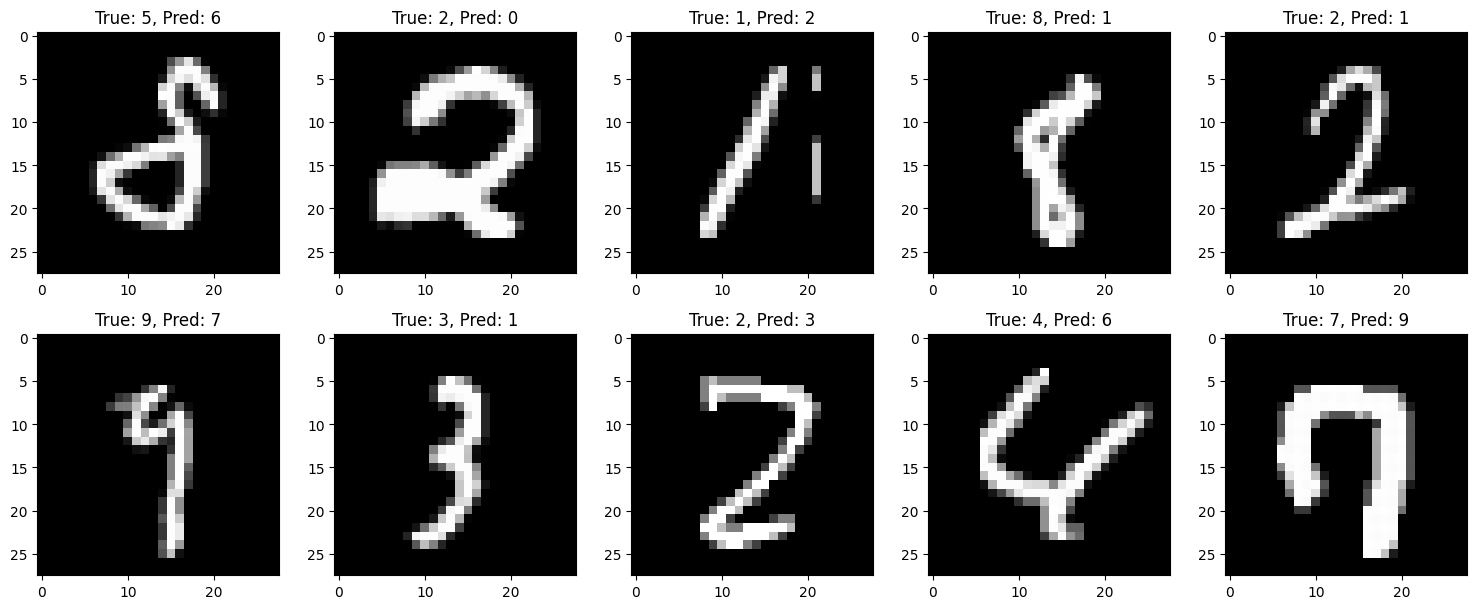

In [50]:
# load params
params = load_params('../assets/mnist_params.pkl')

# get predictions
batched_forward = vmap(forward, in_axes=(None, 0, None))
logits = batched_forward(params, x_test, 'relu')
preds = jnp.argmax(logits, axis=1)

test_acc, test_loss = evaluate_model(params, x_test, y_test, 'relu', classification=True)
print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# get misclassified images
misclassified = jnp.where(preds != y_test)[0]

print(f"We have {len(misclassified)} misclassified images")

# plot misclassified images with correct and predicted labels
num_figures = 10
rows = 4
cols = 5  # rows * cols should be >= num_figures

plt.figure(figsize=(cols * 3, rows * 3))
for i in range(num_figures):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x_test[misclassified[i]].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_test[misclassified[i]]}, Pred: {preds[misclassified[i]]}")
plt.tight_layout()
plt.show()


### (c) Analysis of Misclassified Images

**1. Performance Overview**
The best model (4-layer MLP with ReLU activation) achieved a test accuracy of 95.11%. Out of the test set, the model misclassified 685 images. 

The visualization above displays a sample of these errors. The titles above each image show the `True` label (ground truth) versus the `Pred` (predicted) label.

**2. Categories of Errors**
Upon visual inspection, the errors tend to fall into specific categories:
* **Ambiguous Handwriting:** Many misclassified images are genuinely difficult even for humans to recognize. For example, the "7" with a connected loop can look exactly like a "9".
* **Unusual Styles:** Digits written with extremely thick strokes, breaks in the ink (incomplete loops), or extreme rotations are frequently misclassified. For example, the "2" has a very thick stroke.

**3. Explanations & Model Limitations**
These failures highlight the inherent limitations of Feedforward Networks (MLPs) for image recognition:
* **Loss of Spatial Structure:** Because the input images are flattened into 1D vectors ($784 \times 1$), the model loses the 2D spatial relationships between pixels. It treats pixel $(x, y)$ and pixel $(x+1, y)$ as independent features rather than neighbors, making it significantly harder to recognize shapes like "loops" or "edges" robustly compared to Convolutional Neural Networks (CNNs).
* **Lack of Translation/Rotation Invariance:** If a digit is shifted by a few pixels or slightly rotated, the resulting flattened vector changes significantly. Therefore, the MLP struggles to generalize to these simple variations.

 3. Next, test the performance of your neural network implementation on a simple regression problem. Fit functions of the form

$$f_k(x) := \sin(k\pi x), \quad x \in [-1, 1],$$

with $k \in \mathbb{N}$ using your neural network implementation. Use mean squared error (MSE) as the loss. Generate a sufficient number of training samples yourself, balancing approximation quality and computational cost.


(a) Perform a grid search to find the best hyperparameters for fitting $f_1$, varying at least the parameters that you also tested in Question 2. Discuss your findings.

In [51]:
# Grid search configurations for regression
grid_search_configs = {
    'architectures': [
        # hidden layers
        [1, 16, 1],
        [1, 16, 16, 1],
        [1, 16, 16, 16, 1],
    ],
    
    # Activation functions
    'activations': ['relu', 'tanh'],
    
    # Learning rates
    'learning_rates': [0.1, 0.01],
    
    # Batch sizes
    'batch_sizes': [64, 128],
    
    # Epochs
    'epochs': [50]
}

In [52]:
# We start by generating training samples.
n_samples = 5000
k = 1
x = jnp.linspace(-1, 1, n_samples).reshape(-1, 1)
y = jnp.sin(k * jnp.pi * x)

key = random.PRNGKey(42)
indices = jnp.arange(n_samples)
shuffled_indices = random.permutation(key, indices)
x_shuffled = x[shuffled_indices]
y_shuffled = y[shuffled_indices]

x_train, y_train, x_test, y_test = get_splits(x_shuffled, y_shuffled, classification=False)

# sort the x_test and y_test to plot
sort_idx = jnp.argsort(x_test.flatten())
x_test = x_test[sort_idx]
y_test = y_test[sort_idx]

In [53]:
# We do the same grid search as in Question 2.
# best_config, best_acc, best_loss = grid_search(
#     x_train, y_train, 
#     grid_search_configs, 
#     k=3,
#     classification=False
# )

# print("The best configuration is:")
# print(best_config)
# print(f"Best K-fold Mean Loss: {best_loss:.2f}")

RESULTS:

Total configurations to test: 24
With k=3 folds, total training runs: 72
--------------------------------------------------------------------------------

[1/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.1250, Val Loss = 0.1339
Fold 2, Epoch 0: Train Loss = 0.1294, Val Loss = 0.1192
Fold 3, Epoch 0: Train Loss = 0.1325, Val Loss = 0.1306
Mean Validation Loss: 0.0004
New best configuration!

[2/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.1448, Val Loss = 0.1554
Fold 2, Epoch 0: Train Loss = 0.1540, Val Loss = 0.1430
Fold 3, Epoch 0: Train Loss = 0.1548, Val Loss = 0.1524
Mean Validation Loss: 0.0010

[3/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.1733, Val Loss = 0.1864
Fold 2, Epoch 0: Train Loss = 0.1852, Val Loss = 0.1742
Fold 3, Epoch 0: Train Loss = 0.2920, Val Loss = 0.2883
Mean Validation Loss: 0.0299

[4/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.2034, Val Loss = 0.2177
Fold 2, Epoch 0: Train Loss = 0.2153, Val Loss = 0.2081
Fold 3, Epoch 0: Train Loss = 0.5343, Val Loss = 0.5329
Mean Validation Loss: 0.0764

[5/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.0624, Val Loss = 0.0663
Fold 2, Epoch 0: Train Loss = 0.0550, Val Loss = 0.0507
Fold 3, Epoch 0: Train Loss = 0.0893, Val Loss = 0.0895
Mean Validation Loss: 0.0057

[6/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.0745, Val Loss = 0.0795
Fold 2, Epoch 0: Train Loss = 0.0731, Val Loss = 0.0677
Fold 3, Epoch 0: Train Loss = 0.1043, Val Loss = 0.1049
Mean Validation Loss: 0.0086

[7/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.0868, Val Loss = 0.0937
Fold 2, Epoch 0: Train Loss = 0.0936, Val Loss = 0.0869
Fold 3, Epoch 0: Train Loss = 0.1205, Val Loss = 0.1194
Mean Validation Loss: 0.0182

[8/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.1085, Val Loss = 0.1172
Fold 2, Epoch 0: Train Loss = 0.1038, Val Loss = 0.0973
Fold 3, Epoch 0: Train Loss = 0.2014, Val Loss = 0.1956
Mean Validation Loss: 0.0376

[9/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.0743, Val Loss = 0.0794
Fold 2, Epoch 0: Train Loss = 0.1058, Val Loss = 0.0985
Fold 3, Epoch 0: Train Loss = 0.1120, Val Loss = 0.1117
Mean Validation Loss: 0.0003
New best configuration!

[10/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.1023, Val Loss = 0.1106
Fold 2, Epoch 0: Train Loss = 0.1607, Val Loss = 0.1501
Early stopping at epoch 49
Fold 3, Epoch 0: Train Loss = 0.1494, Val Loss = 0.1473
Mean Validation Loss: 0.0007

[11/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.1645, Val Loss = 0.1754
Fold 2, Epoch 0: Train Loss = 0.1784, Val Loss = 0.1685
Fold 3, Epoch 0: Train Loss = 0.1925, Val Loss = 0.1923
Mean Validation Loss: 0.0072

[12/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.2010, Val Loss = 0.2124
Fold 2, Epoch 0: Train Loss = 0.1948, Val Loss = 0.1838
Fold 3, Epoch 0: Train Loss = 0.2098, Val Loss = 0.2105
Mean Validation Loss: 0.0286

[13/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.0315, Val Loss = 0.0335
Fold 2, Epoch 0: Train Loss = 0.0248, Val Loss = 0.0228
Fold 3, Epoch 0: Train Loss = 0.0502, Val Loss = 0.0504
Mean Validation Loss: 0.0026

[14/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.0360, Val Loss = 0.0388
Fold 2, Epoch 0: Train Loss = 0.0397, Val Loss = 0.0367
Early stopping at epoch 24
Fold 3, Epoch 0: Train Loss = 0.0675, Val Loss = 0.0683
Mean Validation Loss: 0.0071

[15/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.0448, Val Loss = 0.0484
Fold 2, Epoch 0: Train Loss = 0.0287, Val Loss = 0.0263
Fold 3, Epoch 0: Train Loss = 0.0932, Val Loss = 0.0942
Mean Validation Loss: 0.0149

[16/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.0472, Val Loss = 0.0513
Fold 2, Epoch 0: Train Loss = 0.0312, Val Loss = 0.0286
Fold 3, Epoch 0: Train Loss = 0.0986, Val Loss = 0.1002
Mean Validation Loss: 0.0213

[17/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.1074, Val Loss = 0.1151
Fold 2, Epoch 0: Train Loss = 0.0447, Val Loss = 0.0429
Early stopping at epoch 34
Fold 3, Epoch 0: Train Loss = 0.0720, Val Loss = 0.0716
Mean Validation Loss: 0.0007

[18/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.1361, Val Loss = 0.1472
Fold 2, Epoch 0: Train Loss = 0.0939, Val Loss = 0.0941
Fold 3, Epoch 0: Train Loss = 0.1161, Val Loss = 0.1136
Mean Validation Loss: 0.0019

[19/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.2251, Val Loss = 0.2375
Fold 2, Epoch 0: Train Loss = 0.1560, Val Loss = 0.1473
Fold 3, Epoch 0: Train Loss = 0.1579, Val Loss = 0.1575
Mean Validation Loss: 0.0045

[20/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.2848, Val Loss = 0.2982
Fold 2, Epoch 0: Train Loss = 0.1808, Val Loss = 0.1703
Fold 3, Epoch 0: Train Loss = 0.1698, Val Loss = 0.1690
Mean Validation Loss: 0.0232

[21/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.0479, Val Loss = 0.0504
Fold 2, Epoch 0: Train Loss = 0.0222, Val Loss = 0.0208
Fold 3, Epoch 0: Train Loss = 0.0398, Val Loss = 0.0396
Mean Validation Loss: 0.0009

[22/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.0522, Val Loss = 0.0558
Fold 2, Epoch 0: Train Loss = 0.0428, Val Loss = 0.0396
Fold 3, Epoch 0: Train Loss = 0.0515, Val Loss = 0.0521
Mean Validation Loss: 0.0029

[23/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.0560, Val Loss = 0.0602
Fold 2, Epoch 0: Train Loss = 0.0190, Val Loss = 0.0173
Fold 3, Epoch 0: Train Loss = 0.0562, Val Loss = 0.0567
Mean Validation Loss: 0.0079

[24/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.0587, Val Loss = 0.0634
Fold 2, Epoch 0: Train Loss = 0.0235, Val Loss = 0.0214
Fold 3, Epoch 0: Train Loss = 0.0616, Val Loss = 0.0623
Mean Validation Loss: 0.0149

Grid Search Complete!
Best Configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50


Grid Search for $f_1(x) = \sin(\pi x)$

**1. Best Hyperparameters**
After performing a grid search over 24 configurations (evaluated via 3-fold cross-validation), the optimal set of hyperparameters found was:
* **Architecture:** `[1, 16, 16, 1]` (2 hidden layers, 16 neurons each)
* **Activation:** `ReLU`
* **Learning Rate:** `0.1`
* **Batch Size:** `64`
* **Epochs:** `50`
* **Best Validation MSE:** `0.0003`

**2. Discussion of Findings**
* **Architecture Depth:** The best performance was observed with 2 hidden layers. 
    * The shallow network (`[1, 16, 1]`) performed well (MSE: 0.0004) but was slightly outperformed by the 2-layer model.
    * The deepest network (`[1, 16, 16, 16, 1]`) performed worse (MSE: 0.0007), likely due to harder optimization landscapes or overfitting on the small training set.
* **Activation Function:** `ReLU` proved superior to `Tanh` for this regression task. For the same architecture, `ReLU` achieved an MSE of 0.0003 compared to `Tanh`'s 0.0026.
* **Optimizer Dynamics:**
    * **Learning Rate:** A higher learning rate of `0.1` was essential. Models with `lr=0.01` consistently failed to converge to low error rates within 50 epochs (e.g., MSE 0.0072 vs 0.0003).
    * **Batch Size:** The smaller batch size of `64` yielded better generalization than `128`. The stochasticity provided by smaller batches likely helped the model find sharper minima that generalize better to the sinusoidal function.

In [54]:
# We now train the best model on the full training set and save it.
best_config = {
    'layer_widths': [1, 16, 16, 1],
    'activation': 'relu',
    'learning_rate': 0.1,
    'batch_size': 64,
    'epochs': 150
}

# params, test_acc, test_loss, learning_curve = train_model(
#     x_train, y_train, x_test, y_test, best_config, classification=False
# )

# plt.figure(figsize=(12, 5))
# plt.plot(learning_curve['train_loss'], label='Training MSE Loss')
# plt.plot(learning_curve['test_loss'], label='Test MSE Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# save_params(params, filename=f'../assets/{k}_reg_params.pkl')

Below, we provide the training loss vs epochs plot for k = 1: $f_1(x) = \sin(\pi x)$.

![alt text](../Figures/1_reg_training_loss.png "Training Loss vs Epochs")


Parameters loaded from ../assets/1_reg_params.pkl


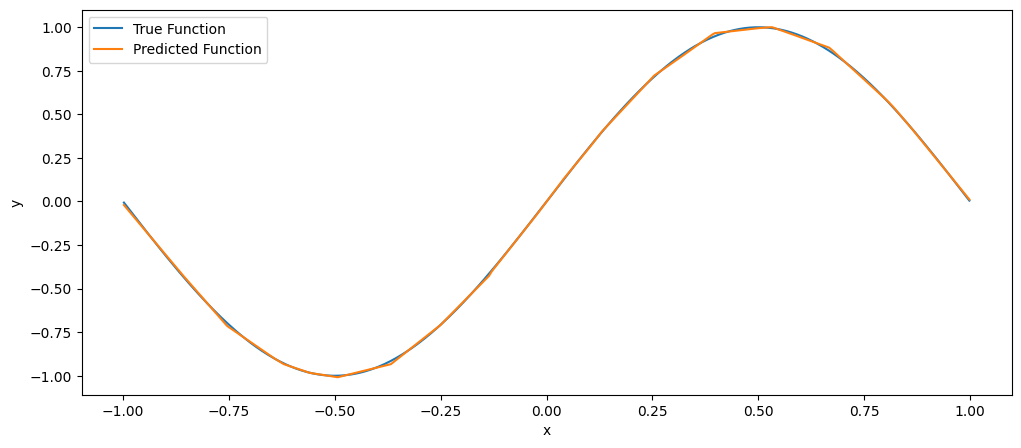

In [55]:
# plot the true function and the predicted function
params = load_params(f'../assets/{k}_reg_params.pkl')

y_pred = forward(params, x_test, best_config['activation'])
plt.figure(figsize=(12, 5))
plt.plot(x_test, y_test, label='True Function')
plt.plot(x_test, y_pred, label='Predicted Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

(b) Try to fit $f_k$ for different values of $k$. How do you need to change the hyperparameters when increasing $k$? Discuss your findings. How far can you increase $k$?



In [56]:
def analyze_k_impact(k_values):
    """
    Runs grid search for different values of k to determine optimal hyperparameters.
    """

    # Store best params for each k
    heuristics = {}
    
    for k in k_values:
        print(f"Analyzing k = {k}")
        
        # Generate Data for this specific k
        n_samples = 5000
        x = jnp.linspace(-1, 1, n_samples).reshape(-1, 1)
        y = jnp.sin(k * jnp.pi * x)
        
        key = random.PRNGKey(k)
        perm = random.permutation(key, n_samples)
        x_shuffled, y_shuffled = x[perm], y[perm]
        
        x_train, y_train, x_test, y_test = get_splits(
            x_shuffled, y_shuffled, train=0.8, classification=False
        )
        
        # Run Grid Search
        # We use k=3 folds to save time, but get reliable results
        best_cfg, best_acc, best_loss = grid_search(
            x_train, y_train, 
            grid_search_configs, 
            k=3, 
            classification=False
        )
        
        heuristics[k] = {
            'config': best_cfg,
            'loss': best_loss
        }

    return heuristics

# We test low, medium, and high frequencies
# k_list = [5, 10, 20, 100]
# k_heuristics = analyze_k_impact(k_list)
# print(k_heuristics)

This is the training results for the best k model:
Analyzing k = 5
Total configurations to test: 24
With k=3 folds, total training runs: 72


[1/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4878, Val Loss = 0.4747
Fold 2, Epoch 0: Train Loss = 0.4752, Val Loss = 0.4990
Fold 3, Epoch 0: Train Loss = 0.4919, Val Loss = 0.4830
Early stopping at epoch 11
Mean Validation Loss: 0.4809
New best configuration!

[2/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4883, Val Loss = 0.4749
Fold 2, Epoch 0: Train Loss = 0.4785, Val Loss = 0.5013
Fold 3, Epoch 0: Train Loss = 0.4900, Val Loss = 0.4804
Mean Validation Loss: 0.4820

[3/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4904, Val Loss = 0.4775
Fold 2, Epoch 0: Train Loss = 0.4814, Val Loss = 0.5069
Fold 3, Epoch 0: Train Loss = 0.5360, Val Loss = 0.5194
Mean Validation Loss: 0.4820

[4/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4936, Val Loss = 0.4813
Fold 2, Epoch 0: Train Loss = 0.4932, Val Loss = 0.5195
Fold 3, Epoch 0: Train Loss = 0.6434, Val Loss = 0.6190
Mean Validation Loss: 0.4823

[5/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5000, Val Loss = 0.4880
Fold 2, Epoch 0: Train Loss = 0.4793, Val Loss = 0.5042
Fold 3, Epoch 0: Train Loss = 0.5127, Val Loss = 0.5040
Mean Validation Loss: 0.4784
New best configuration!

[6/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5047, Val Loss = 0.4925
Fold 2, Epoch 0: Train Loss = 0.4845, Val Loss = 0.5074
Fold 3, Epoch 0: Train Loss = 0.4981, Val Loss = 0.4881
Mean Validation Loss: 0.4736
New best configuration!

[7/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5092, Val Loss = 0.4970
Fold 2, Epoch 0: Train Loss = 0.4875, Val Loss = 0.5121
Fold 3, Epoch 0: Train Loss = 0.4970, Val Loss = 0.4856
Mean Validation Loss: 0.4788

[8/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5103, Val Loss = 0.4977
Fold 2, Epoch 0: Train Loss = 0.4894, Val Loss = 0.5154
Fold 3, Epoch 0: Train Loss = 0.5301, Val Loss = 0.5166
Mean Validation Loss: 0.4839

[9/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4853, Val Loss = 0.4726
Fold 2, Epoch 0: Train Loss = 0.4693, Val Loss = 0.4923
Fold 3, Epoch 0: Train Loss = 0.4734, Val Loss = 0.4638
Mean Validation Loss: 0.3038
New best configuration!

[10/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4862, Val Loss = 0.4731
Early stopping at epoch 41
Fold 2, Epoch 0: Train Loss = 0.4784, Val Loss = 0.4992
Early stopping at epoch 28
Fold 3, Epoch 0: Train Loss = 0.4811, Val Loss = 0.4702
Early stopping at epoch 22
Mean Validation Loss: 0.4417

[11/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4954, Val Loss = 0.4815
Fold 2, Epoch 0: Train Loss = 0.4796, Val Loss = 0.5013
Fold 3, Epoch 0: Train Loss = 0.5032, Val Loss = 0.4919
Mean Validation Loss: 0.4549

[12/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5027, Val Loss = 0.4884
Fold 2, Epoch 0: Train Loss = 0.4809, Val Loss = 0.5023
Fold 3, Epoch 0: Train Loss = 0.5488, Val Loss = 0.5389
Mean Validation Loss: 0.4656

[13/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4975, Val Loss = 0.4852
Fold 2, Epoch 0: Train Loss = 0.4785, Val Loss = 0.5061
Fold 3, Epoch 0: Train Loss = 0.5193, Val Loss = 0.5114
Mean Validation Loss: 0.3957

[14/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5049, Val Loss = 0.4920
Fold 2, Epoch 0: Train Loss = 0.4844, Val Loss = 0.5075
Fold 3, Epoch 0: Train Loss = 0.4925, Val Loss = 0.4827
Mean Validation Loss: 0.4107

[15/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5207, Val Loss = 0.5070
Fold 2, Epoch 0: Train Loss = 0.5249, Val Loss = 0.5467
Fold 3, Epoch 0: Train Loss = 0.4904, Val Loss = 0.4800
Mean Validation Loss: 0.4693

[16/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5239, Val Loss = 0.5098
Fold 2, Epoch 0: Train Loss = 0.5322, Val Loss = 0.5548
Fold 3, Epoch 0: Train Loss = 0.4967, Val Loss = 0.4872
Mean Validation Loss: 0.4775

[17/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4866, Val Loss = 0.4740
Fold 2, Epoch 0: Train Loss = 0.4413, Val Loss = 0.4679
Fold 3, Epoch 0: Train Loss = 0.4949, Val Loss = 0.4850
Mean Validation Loss: 0.1767
New best configuration!

[18/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4889, Val Loss = 0.4759
Early stopping at epoch 30
Fold 2, Epoch 0: Train Loss = 0.4656, Val Loss = 0.4900
Fold 3, Epoch 0: Train Loss = 0.4857, Val Loss = 0.4759
Mean Validation Loss: 0.2735

[19/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4923, Val Loss = 0.4778
Fold 2, Epoch 0: Train Loss = 0.4776, Val Loss = 0.4997
Fold 3, Epoch 0: Train Loss = 0.4876, Val Loss = 0.4766
Mean Validation Loss: 0.4111

[20/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4960, Val Loss = 0.4808
Fold 2, Epoch 0: Train Loss = 0.4808, Val Loss = 0.5019
Fold 3, Epoch 0: Train Loss = 0.4919, Val Loss = 0.4811
Mean Validation Loss: 0.4473

[21/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4766, Val Loss = 0.4624
Fold 2, Epoch 0: Train Loss = 0.4638, Val Loss = 0.4902
Fold 3, Epoch 0: Train Loss = 0.5491, Val Loss = 0.5424
Mean Validation Loss: 0.1991

[22/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4835, Val Loss = 0.4691
Fold 2, Epoch 0: Train Loss = 0.4710, Val Loss = 0.4933
Early stopping at epoch 31
Fold 3, Epoch 0: Train Loss = 0.5005, Val Loss = 0.4905
Mean Validation Loss: 0.3798

[23/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4940, Val Loss = 0.4790
Fold 2, Epoch 0: Train Loss = 0.5329, Val Loss = 0.5538
Fold 3, Epoch 0: Train Loss = 0.5061, Val Loss = 0.4964
Mean Validation Loss: 0.4146

[24/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4969, Val Loss = 0.4817
Fold 2, Epoch 0: Train Loss = 0.5401, Val Loss = 0.5617
Fold 3, Epoch 0: Train Loss = 0.5050, Val Loss = 0.4946
Mean Validation Loss: 0.4476


Grid Search Complete!
Best Configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50

Analyzing k = 10
Total configurations to test: 24
With k=3 folds, total training runs: 72


[1/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5179, Val Loss = 0.5376
Early stopping at epoch 12
Fold 2, Epoch 0: Train Loss = 0.4983, Val Loss = 0.4951
Fold 3, Epoch 0: Train Loss = 0.4982, Val Loss = 0.4924
Mean Validation Loss: 0.5057
New best configuration!

[2/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5010, Val Loss = 0.5180
Early stopping at epoch 14
Fold 2, Epoch 0: Train Loss = 0.4989, Val Loss = 0.4958
Fold 3, Epoch 0: Train Loss = 0.4986, Val Loss = 0.4931
Mean Validation Loss: 0.4984
New best configuration!

[3/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4967, Val Loss = 0.5129
Early stopping at epoch 32
Fold 2, Epoch 0: Train Loss = 0.5025, Val Loss = 0.4996
Fold 3, Epoch 0: Train Loss = 0.5262, Val Loss = 0.5416
Mean Validation Loss: 0.4944
New best configuration!

[4/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5051, Val Loss = 0.5249
Fold 2, Epoch 0: Train Loss = 0.5110, Val Loss = 0.5087
Fold 3, Epoch 0: Train Loss = 0.5880, Val Loss = 0.6222
Mean Validation Loss: 0.4943
New best configuration!

[5/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5056, Val Loss = 0.5245
Fold 2, Epoch 0: Train Loss = 0.4982, Val Loss = 0.4946
Fold 3, Epoch 0: Train Loss = 0.4977, Val Loss = 0.4905
Mean Validation Loss: 0.5007

[6/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4939, Val Loss = 0.5109
Early stopping at epoch 11
Fold 2, Epoch 0: Train Loss = 0.4985, Val Loss = 0.4950
Fold 3, Epoch 0: Train Loss = 0.4979, Val Loss = 0.4929
Mean Validation Loss: 0.4978

[7/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4885, Val Loss = 0.5041
Early stopping at epoch 12
Fold 2, Epoch 0: Train Loss = 0.4973, Val Loss = 0.4927
Fold 3, Epoch 0: Train Loss = 0.4985, Val Loss = 0.4957
Mean Validation Loss: 0.4952

[8/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4887, Val Loss = 0.5048
Early stopping at epoch 14
Fold 2, Epoch 0: Train Loss = 0.4972, Val Loss = 0.4913
Early stopping at epoch 11
Fold 3, Epoch 0: Train Loss = 0.5202, Val Loss = 0.5316
Mean Validation Loss: 0.4954

[9/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5212, Val Loss = 0.5416
Fold 2, Epoch 0: Train Loss = 0.4990, Val Loss = 0.4962
Fold 3, Epoch 0: Train Loss = 0.5029, Val Loss = 0.4993
Mean Validation Loss: 0.4927
New best configuration!

[10/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5034, Val Loss = 0.5200
Fold 2, Epoch 0: Train Loss = 0.5006, Val Loss = 0.4974
Fold 3, Epoch 0: Train Loss = 0.5005, Val Loss = 0.4961
Mean Validation Loss: 0.4921
New best configuration!

[11/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4995, Val Loss = 0.5123
Fold 2, Epoch 0: Train Loss = 0.5056, Val Loss = 0.5006
Fold 3, Epoch 0: Train Loss = 0.5251, Val Loss = 0.5037
Mean Validation Loss: 0.4932

[12/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5043, Val Loss = 0.5185
Fold 2, Epoch 0: Train Loss = 0.5075, Val Loss = 0.5028
Fold 3, Epoch 0: Train Loss = 0.6027, Val Loss = 0.5583
Mean Validation Loss: 0.4938

[13/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5207, Val Loss = 0.5468
Fold 2, Epoch 0: Train Loss = 0.4967, Val Loss = 0.4931
Fold 3, Epoch 0: Train Loss = 0.5003, Val Loss = 0.4918
Mean Validation Loss: 0.5012

[14/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5183, Val Loss = 0.5330
Fold 2, Epoch 0: Train Loss = 0.4951, Val Loss = 0.4905
Early stopping at epoch 38
Fold 3, Epoch 0: Train Loss = 0.5006, Val Loss = 0.4965
Mean Validation Loss: 0.4994

[15/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4932, Val Loss = 0.5112
Fold 2, Epoch 0: Train Loss = 0.5014, Val Loss = 0.4964
Early stopping at epoch 23
Fold 3, Epoch 0: Train Loss = 0.5017, Val Loss = 0.4934
Mean Validation Loss: 0.4965

[16/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4926, Val Loss = 0.5088
Fold 2, Epoch 0: Train Loss = 0.5019, Val Loss = 0.4962
Early stopping at epoch 34
Fold 3, Epoch 0: Train Loss = 0.5097, Val Loss = 0.4924
Early stopping at epoch 11
Mean Validation Loss: 0.4961

[17/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5082, Val Loss = 0.5295
Early stopping at epoch 11
Fold 2, Epoch 0: Train Loss = 0.4957, Val Loss = 0.4919
Fold 3, Epoch 0: Train Loss = 0.4979, Val Loss = 0.4933
Mean Validation Loss: 0.4496
New best configuration!

[18/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4971, Val Loss = 0.5155
Fold 2, Epoch 0: Train Loss = 0.4976, Val Loss = 0.4920
Fold 3, Epoch 0: Train Loss = 0.5003, Val Loss = 0.4946
Mean Validation Loss: 0.4763

[19/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4930, Val Loss = 0.5086
Fold 2, Epoch 0: Train Loss = 0.5029, Val Loss = 0.5002
Fold 3, Epoch 0: Train Loss = 0.5034, Val Loss = 0.4927
Mean Validation Loss: 0.4858

[20/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4936, Val Loss = 0.5095
Fold 2, Epoch 0: Train Loss = 0.5113, Val Loss = 0.5109
Fold 3, Epoch 0: Train Loss = 0.5135, Val Loss = 0.4960
Mean Validation Loss: 0.4889

[21/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5097, Val Loss = 0.5318
Fold 2, Epoch 0: Train Loss = 0.4988, Val Loss = 0.4960
Fold 3, Epoch 0: Train Loss = 0.4995, Val Loss = 0.4900
Mean Validation Loss: 0.4993

[22/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5168, Val Loss = 0.5305
Fold 2, Epoch 0: Train Loss = 0.4971, Val Loss = 0.4952
Fold 3, Epoch 0: Train Loss = 0.4995, Val Loss = 0.4951
Mean Validation Loss: 0.4970

[23/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4927, Val Loss = 0.5123
Fold 2, Epoch 0: Train Loss = 0.4963, Val Loss = 0.4958
Fold 3, Epoch 0: Train Loss = 0.4973, Val Loss = 0.4899
Mean Validation Loss: 0.4955

[24/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.4916, Val Loss = 0.5099
Fold 2, Epoch 0: Train Loss = 0.4960, Val Loss = 0.4951
Fold 3, Epoch 0: Train Loss = 0.4973, Val Loss = 0.4900
Mean Validation Loss: 0.4959


Grid Search Complete!
Best Configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50

Analyzing k = 20
Total configurations to test: 24
With k=3 folds, total training runs: 72


[1/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5112, Val Loss = 0.4857
Early stopping at epoch 11
Fold 2, Epoch 0: Train Loss = 0.4961, Val Loss = 0.5071
Early stopping at epoch 26
Fold 3, Epoch 0: Train Loss = 0.4937, Val Loss = 0.5085
Mean Validation Loss: 0.4998
New best configuration!

[2/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5104, Val Loss = 0.4834
Early stopping at epoch 11
Fold 2, Epoch 0: Train Loss = 0.5003, Val Loss = 0.5136
Fold 3, Epoch 0: Train Loss = 0.4957, Val Loss = 0.5119
Mean Validation Loss: 0.5004

[3/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5117, Val Loss = 0.4834
Early stopping at epoch 16
Fold 2, Epoch 0: Train Loss = 0.5001, Val Loss = 0.5160
Fold 3, Epoch 0: Train Loss = 0.5274, Val Loss = 0.5458
Mean Validation Loss: 0.4983
New best configuration!

[4/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5197, Val Loss = 0.4920
Early stopping at epoch 22
Fold 2, Epoch 0: Train Loss = 0.5104, Val Loss = 0.5257
Fold 3, Epoch 0: Train Loss = 0.5986, Val Loss = 0.6168
Mean Validation Loss: 0.4983

[5/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5100, Val Loss = 0.4836
Early stopping at epoch 11
Fold 2, Epoch 0: Train Loss = 0.4966, Val Loss = 0.5077
Fold 3, Epoch 0: Train Loss = 0.4980, Val Loss = 0.5158
Mean Validation Loss: 0.5016

[6/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5103, Val Loss = 0.4849
Early stopping at epoch 14
Fold 2, Epoch 0: Train Loss = 0.4949, Val Loss = 0.5068
Fold 3, Epoch 0: Train Loss = 0.4938, Val Loss = 0.5085
Early stopping at epoch 15
Mean Validation Loss: 0.4999

[7/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5079, Val Loss = 0.4821
Early stopping at epoch 11
Fold 2, Epoch 0: Train Loss = 0.4952, Val Loss = 0.5057
Early stopping at epoch 11
Fold 3, Epoch 0: Train Loss = 0.4940, Val Loss = 0.5105
Early stopping at epoch 43
Mean Validation Loss: 0.4988

[8/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5077, Val Loss = 0.4818
Early stopping at epoch 11
Fold 2, Epoch 0: Train Loss = 0.4959, Val Loss = 0.5058
Early stopping at epoch 12
Fold 3, Epoch 0: Train Loss = 0.5173, Val Loss = 0.5389
Mean Validation Loss: 0.4988

[9/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5160, Val Loss = 0.4918
Fold 2, Epoch 0: Train Loss = 0.4970, Val Loss = 0.5069
Early stopping at epoch 11
Fold 3, Epoch 0: Train Loss = 0.5009, Val Loss = 0.5136
Mean Validation Loss: 0.4993

[10/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5106, Val Loss = 0.4840
Early stopping at epoch 11
Fold 2, Epoch 0: Train Loss = 0.4996, Val Loss = 0.5084
Fold 3, Epoch 0: Train Loss = 0.5034, Val Loss = 0.5221
Mean Validation Loss: 0.4997

[11/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5155, Val Loss = 0.4844
Early stopping at epoch 15
Fold 2, Epoch 0: Train Loss = 0.5011, Val Loss = 0.5067
Early stopping at epoch 13
Fold 3, Epoch 0: Train Loss = 0.5149, Val Loss = 0.5249
Mean Validation Loss: 0.4982
New best configuration!

[12/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5214, Val Loss = 0.4900
Early stopping at epoch 20
Fold 2, Epoch 0: Train Loss = 0.5025, Val Loss = 0.5095
Early stopping at epoch 17
Fold 3, Epoch 0: Train Loss = 0.5834, Val Loss = 0.5832
Mean Validation Loss: 0.4982

[13/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5159, Val Loss = 0.4882
Early stopping at epoch 22
Fold 2, Epoch 0: Train Loss = 0.5387, Val Loss = 0.5444
Fold 3, Epoch 0: Train Loss = 0.5133, Val Loss = 0.5325
Mean Validation Loss: 0.5000

[14/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5106, Val Loss = 0.4851
Early stopping at epoch 16
Fold 2, Epoch 0: Train Loss = 0.4972, Val Loss = 0.5100
Fold 3, Epoch 0: Train Loss = 0.4948, Val Loss = 0.5089
Early stopping at epoch 33
Mean Validation Loss: 0.4995

[15/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5137, Val Loss = 0.4893
Fold 2, Epoch 0: Train Loss = 0.5059, Val Loss = 0.5132
Early stopping at epoch 23
Fold 3, Epoch 0: Train Loss = 0.4955, Val Loss = 0.5086
Mean Validation Loss: 0.4987

[16/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5140, Val Loss = 0.4894
Fold 2, Epoch 0: Train Loss = 0.5080, Val Loss = 0.5151
Early stopping at epoch 36
Fold 3, Epoch 0: Train Loss = 0.5032, Val Loss = 0.5132
Early stopping at epoch 12
Mean Validation Loss: 0.4986

[17/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5121, Val Loss = 0.4878
Fold 2, Epoch 0: Train Loss = 0.4963, Val Loss = 0.5062
Fold 3, Epoch 0: Train Loss = 0.5136, Val Loss = 0.5243
Mean Validation Loss: 0.4952
New best configuration!

[18/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5086, Val Loss = 0.4832
Fold 2, Epoch 0: Train Loss = 0.4947, Val Loss = 0.5065
Fold 3, Epoch 0: Train Loss = 0.5440, Val Loss = 0.5682
Mean Validation Loss: 0.4970

[19/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5082, Val Loss = 0.4812
Fold 2, Epoch 0: Train Loss = 0.4963, Val Loss = 0.5066
Fold 3, Epoch 0: Train Loss = 0.4972, Val Loss = 0.5107
Mean Validation Loss: 0.4962

[20/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5090, Val Loss = 0.4819
Early stopping at epoch 13
Fold 2, Epoch 0: Train Loss = 0.5021, Val Loss = 0.5159
Fold 3, Epoch 0: Train Loss = 0.5042, Val Loss = 0.5160
Mean Validation Loss: 0.4972

[21/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5085, Val Loss = 0.4845
Fold 2, Epoch 0: Train Loss = 0.5000, Val Loss = 0.5111
Early stopping at epoch 47
Fold 3, Epoch 0: Train Loss = 0.5582, Val Loss = 0.5833
Mean Validation Loss: 0.4997

[22/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5080, Val Loss = 0.4848
Early stopping at epoch 13
Fold 2, Epoch 0: Train Loss = 0.4959, Val Loss = 0.5090
Fold 3, Epoch 0: Train Loss = 0.4942, Val Loss = 0.5108
Early stopping at epoch 40
Mean Validation Loss: 0.4998

[23/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5103, Val Loss = 0.4876
Fold 2, Epoch 0: Train Loss = 0.5012, Val Loss = 0.5088
Fold 3, Epoch 0: Train Loss = 0.4941, Val Loss = 0.5097
Early stopping at epoch 17
Mean Validation Loss: 0.4996

[24/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5102, Val Loss = 0.4874
Fold 2, Epoch 0: Train Loss = 0.5021, Val Loss = 0.5092
Fold 3, Epoch 0: Train Loss = 0.4945, Val Loss = 0.5094
Early stopping at epoch 25
Mean Validation Loss: 0.4995


Grid Search Complete!
Best Configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50

Analyzing k = 100
Total configurations to test: 24
With k=3 folds, total training runs: 72


[1/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5126, Val Loss = 0.4992
Fold 2, Epoch 0: Train Loss = 0.5023, Val Loss = 0.5028
Early stopping at epoch 11
Fold 3, Epoch 0: Train Loss = 0.4989, Val Loss = 0.5092
Early stopping at epoch 12
Mean Validation Loss: 0.5032
New best configuration!

[2/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5082, Val Loss = 0.4948
Early stopping at epoch 17
Fold 2, Epoch 0: Train Loss = 0.5136, Val Loss = 0.5190
Early stopping at epoch 11
Fold 3, Epoch 0: Train Loss = 0.5017, Val Loss = 0.5112
Early stopping at epoch 13
Mean Validation Loss: 0.5077

[3/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5083, Val Loss = 0.4951
Fold 2, Epoch 0: Train Loss = 0.5074, Val Loss = 0.5070
Early stopping at epoch 15
Fold 3, Epoch 0: Train Loss = 0.5396, Val Loss = 0.5537
Early stopping at epoch 24
Mean Validation Loss: 0.5028
New best configuration!

[4/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5144, Val Loss = 0.4990
Fold 2, Epoch 0: Train Loss = 0.5170, Val Loss = 0.5183
Early stopping at epoch 21
Fold 3, Epoch 0: Train Loss = 0.6182, Val Loss = 0.6407
Early stopping at epoch 40
Mean Validation Loss: 0.5023
New best configuration!

[5/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5139, Val Loss = 0.4993
Early stopping at epoch 16
Fold 2, Epoch 0: Train Loss = 0.5015, Val Loss = 0.5084
Fold 3, Epoch 0: Train Loss = 0.5026, Val Loss = 0.5120
Early stopping at epoch 11
Mean Validation Loss: 0.5057

[6/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5122, Val Loss = 0.4957
Early stopping at epoch 23
Fold 2, Epoch 0: Train Loss = 0.5022, Val Loss = 0.5112
Early stopping at epoch 36
Fold 3, Epoch 0: Train Loss = 0.4992, Val Loss = 0.5086
Early stopping at epoch 11
Mean Validation Loss: 0.5039

[7/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5104, Val Loss = 0.4958
Fold 2, Epoch 0: Train Loss = 0.5013, Val Loss = 0.5084
Fold 3, Epoch 0: Train Loss = 0.4994, Val Loss = 0.5090
Early stopping at epoch 11
Mean Validation Loss: 0.5031

[8/24] Testing configuration:
Architecture: [1, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5105, Val Loss = 0.4956
Fold 2, Epoch 0: Train Loss = 0.5013, Val Loss = 0.5068
Early stopping at epoch 11
Fold 3, Epoch 0: Train Loss = 0.5242, Val Loss = 0.5334
Early stopping at epoch 13
Mean Validation Loss: 0.5032

[9/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5128, Val Loss = 0.4993
Fold 2, Epoch 0: Train Loss = 0.5027, Val Loss = 0.5080
Early stopping at epoch 12
Fold 3, Epoch 0: Train Loss = 0.4975, Val Loss = 0.5128
Early stopping at epoch 22
Mean Validation Loss: 0.5049

[10/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5084, Val Loss = 0.4955
Early stopping at epoch 14
Fold 2, Epoch 0: Train Loss = 0.5092, Val Loss = 0.5163
Fold 3, Epoch 0: Train Loss = 0.4984, Val Loss = 0.5138
Mean Validation Loss: 0.5053

[11/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5106, Val Loss = 0.5004
Early stopping at epoch 25
Fold 2, Epoch 0: Train Loss = 0.5083, Val Loss = 0.5162
Early stopping at epoch 24
Fold 3, Epoch 0: Train Loss = 0.5171, Val Loss = 0.5355
Mean Validation Loss: 0.5054

[12/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5150, Val Loss = 0.5045
Fold 2, Epoch 0: Train Loss = 0.5093, Val Loss = 0.5171
Early stopping at epoch 35
Fold 3, Epoch 0: Train Loss = 0.5784, Val Loss = 0.6030
Mean Validation Loss: 0.5048

[13/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5458, Val Loss = 0.5387
Fold 2, Epoch 0: Train Loss = 0.5053, Val Loss = 0.5093
Early stopping at epoch 18
Fold 3, Epoch 0: Train Loss = 0.5041, Val Loss = 0.5162
Mean Validation Loss: 0.5059

[14/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5160, Val Loss = 0.4996
Fold 2, Epoch 0: Train Loss = 0.5022, Val Loss = 0.5105
Early stopping at epoch 17
Fold 3, Epoch 0: Train Loss = 0.4987, Val Loss = 0.5097
Early stopping at epoch 11
Mean Validation Loss: 0.5041

[15/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5176, Val Loss = 0.5037
Fold 2, Epoch 0: Train Loss = 0.5146, Val Loss = 0.5351
Fold 3, Epoch 0: Train Loss = 0.4992, Val Loss = 0.5108
Early stopping at epoch 12
Mean Validation Loss: 0.5047

[16/24] Testing configuration:
Architecture: [1, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5181, Val Loss = 0.5048
Fold 2, Epoch 0: Train Loss = 0.5170, Val Loss = 0.5382
Fold 3, Epoch 0: Train Loss = 0.5083, Val Loss = 0.5200
Early stopping at epoch 13
Mean Validation Loss: 0.5045

[17/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5113, Val Loss = 0.4975
Fold 2, Epoch 0: Train Loss = 0.5030, Val Loss = 0.5091
Early stopping at epoch 30
Fold 3, Epoch 0: Train Loss = 0.4984, Val Loss = 0.5102
Early stopping at epoch 12
Mean Validation Loss: 0.5043

[18/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5084, Val Loss = 0.4949
Fold 2, Epoch 0: Train Loss = 0.5025, Val Loss = 0.5087
Early stopping at epoch 26
Fold 3, Epoch 0: Train Loss = 0.5006, Val Loss = 0.5115
Early stopping at epoch 13
Mean Validation Loss: 0.5041

[19/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5067, Val Loss = 0.4940
Early stopping at epoch 39
Fold 2, Epoch 0: Train Loss = 0.5042, Val Loss = 0.5093
Early stopping at epoch 19
Fold 3, Epoch 0: Train Loss = 0.4996, Val Loss = 0.5134
Early stopping at epoch 19
Mean Validation Loss: 0.5044

[20/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5069, Val Loss = 0.4942
Fold 2, Epoch 0: Train Loss = 0.5155, Val Loss = 0.5222
Fold 3, Epoch 0: Train Loss = 0.5058, Val Loss = 0.5204
Early stopping at epoch 42
Mean Validation Loss: 0.5063

[21/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5556, Val Loss = 0.5515
Fold 2, Epoch 0: Train Loss = 0.5013, Val Loss = 0.5062
Early stopping at epoch 11
Fold 3, Epoch 0: Train Loss = 0.5103, Val Loss = 0.5223
Early stopping at epoch 34
Mean Validation Loss: 0.5051

[22/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.1
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5105, Val Loss = 0.4978
Fold 2, Epoch 0: Train Loss = 0.5020, Val Loss = 0.5063
Early stopping at epoch 11
Fold 3, Epoch 0: Train Loss = 0.5001, Val Loss = 0.5099
Early stopping at epoch 11
Mean Validation Loss: 0.5036

[23/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 64
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5111, Val Loss = 0.5004
Fold 2, Epoch 0: Train Loss = 0.5075, Val Loss = 0.5300
Fold 3, Epoch 0: Train Loss = 0.5016, Val Loss = 0.5090
Early stopping at epoch 13
Mean Validation Loss: 0.5053

[24/24] Testing configuration:
Architecture: [1, 16, 16, 16, 1]
Activation: tanh
Learning Rate: 0.01
Batch Size: 128
Epochs: 50
Fold 1, Epoch 0: Train Loss = 0.5111, Val Loss = 0.5004
Fold 2, Epoch 0: Train Loss = 0.5093, Val Loss = 0.5330
Fold 3, Epoch 0: Train Loss = 0.5030, Val Loss = 0.5098
Early stopping at epoch 16
Mean Validation Loss: 0.5063


Grid Search Complete!
Best Configuration:
Architecture: [1, 16, 1]
Activation: relu
Learning Rate: 0.01
Batch Size: 128
Epochs: 50

{5: {'config': {'layer_widths': [1, 16, 16, 16, 1], 'activation': 'relu', 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50}, 'loss': np.float32(0.17667484)}, 10: {'config': {'layer_widths': [1, 16, 16, 16, 1], 'activation': 'relu', 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50}, 'loss': np.float32(0.4496317)}, 20: {'config': {'layer_widths': [1, 16, 16, 16, 1], 'activation': 'relu', 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50}, 'loss': np.float32(0.49519762)}, 100: {'config': {'layer_widths': [1, 16, 1], 'activation': 'relu', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50}, 'loss': np.float32(0.50226957)}}


(b) Hyperparameter Tuning for Varying Frequencies $k$: The problem showcases the spectral bias problem of neural networks: neural network fit lower frequencies better than higher frequencies. As can be seen above, the grid search results illustrate the difficulty of fitting high-frequency functions with standard MLPs. There is a sharp performance drop-off as $k$ increases. While the network capacity (Universal Approximation Theorem) theoretically exists to fit these functions, optimization to find those set of weights fails. To push the boundary slightly (e.g., from $k=1$ to $k=5$), increasing depth helps. However, for high $k$ ($>10$), simply changing width, depth, or learning rate is insufficient. Therefore, for a standard MLP with this setup, the limit is approximately $k \approx 5$ to $10$. Beyond this, the model fails to capture the signal and converges to a trivial solution (predicting zero). Addressing this requires a fundamental change in how the input is represented (e.g., Fourier Features) rather than just hyperparameter tuning.

(c) Finally, propose an approach to approximate $f_k$ with higher values of $k$ and test it. Examples could include different function spaces than neural networks, architectural tweaks, activation changes, initialization strategies, or training approaches. Motivate your choice and discuss your findings.

Parameters loaded from ../assets/40_reg_params.pkl


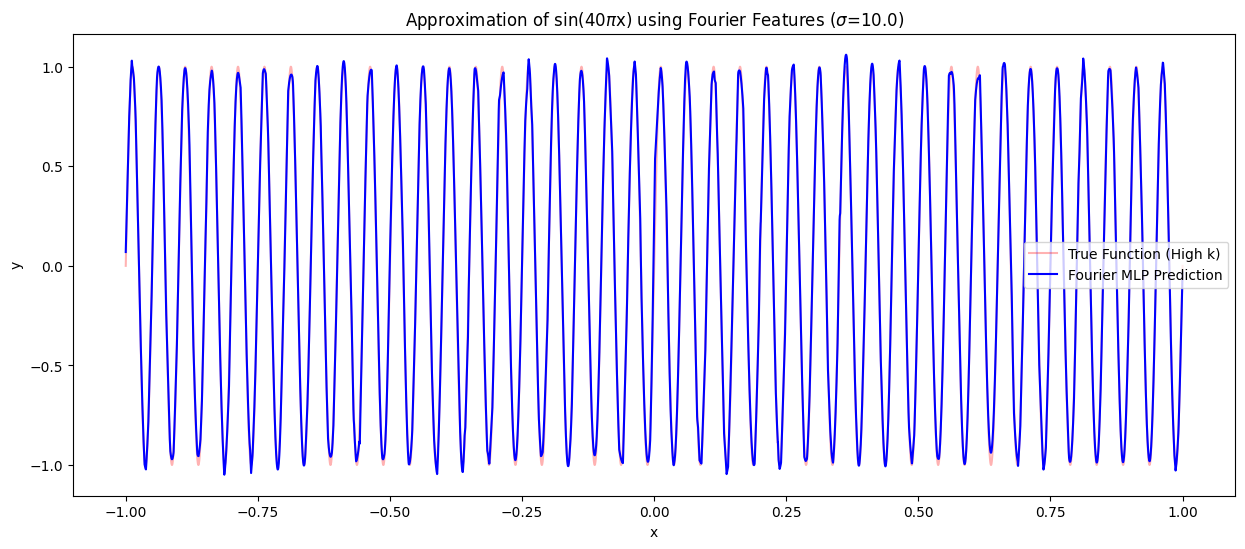

In [57]:
# The Fourier Feature Mapping function
def input_mapping(x, B):
    """
    Maps input x to Fourier features.
    """
    if B is None:
        return x
    xp = 2 * jnp.pi * (x @ B)

    return jnp.sin(xp)

k_high = 40
n_samples = 5000
x = jnp.linspace(-1, 1, n_samples).reshape(-1, 1)
y = jnp.sin(k_high * jnp.pi * x)

mapping_size = 128
scale = 10.0 # Sigma: Controls the frequency bandwidth
key = random.PRNGKey(42)
B = random.normal(key, (1, mapping_size)) * scale
params = None

x_mapped = input_mapping(x, B)
indices = jnp.arange(n_samples)
shuffled_indices = random.permutation(key, indices)
x_shuffled = x_mapped[shuffled_indices]
y_shuffled = y[shuffled_indices]
x_train, y_train, x_test, y_test = get_splits(x_shuffled, y_shuffled, classification=False)

input_dim = mapping_size

best_config = {
    'layer_widths': [input_dim, 8, 8, 1],
    'activation': 'relu',
    'learning_rate': 0.1,
    'batch_size': 64,
    'epochs': 100
}

x_plot = jnp.linspace(-1, 1, 10000).reshape(-1, 1)
x_plot_mapped = input_mapping(x_plot, B)

# print(f"Training on f_{k_high} with Fourier Features...")

# params, test_acc, test_loss, learning_curve = train_model(
#     x_train, y_train, x_test, y_test, best_config, classification=False
# )

# save_params(params, filename=f'../assets/{k_high}_reg_params.pkl')

params = load_params(f'../assets/{k_high}_reg_params.pkl') if params is None else params
y_pred = forward(params, x_plot_mapped, best_config['activation'])

plt.figure(figsize=(15, 6))
plt.plot(x, y, color='red', alpha=0.3, label='True Function (High k)')
plt.plot(x_plot, y_pred, color='blue', label='Fourier MLP Prediction')
plt.title(f"Approximation of sin({k_high}$\pi$x) using Fourier Features ($\sigma$={scale})")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# plt.figure(figsize=(12, 5))
# plt.plot(learning_curve['train_loss'], label='Train Loss')
# plt.plot(learning_curve['test_loss'], label='Test Loss')
# plt.yscale('log')
# plt.title('Loss Curve (Log Scale)')
# plt.legend()
# plt.show()

Discussion: To enable the neural network to approximate high-frequency functions (e.g., $k=20$), we implemented Fourier Feature Mapping. Instead of feeding the raw scalar input $x$ directly into the MLP, the input is projected into a higher-dimensional embedding using sinusoidal functions before passing it to the network. By using a Fourier mapping, we transform the Neural Tangent Kernel (NTK) of the network into a stationary kernel. The scale parameter $\sigma$ of the random matrix $\mathbf{B}$ acts as a bandwidth control. Setting a higher $\sigma$ allows the network to capture higher frequency components consistent with the target function $f_k(x)$.